# Imports

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="1,2,3"

In [3]:
#!/usr/bin/env python
# coding=utf-8
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os

from nda import log
from nda.problems import LogisticRegression, RobustLinearRegression, NN
from nda.optimizers import GD, SGD
from nda.optimizers.utils import generate_mixing_matrix
from nda.experiment_utils import run_exp

from optimizers import CDP_SGD, SoteriaFL, LDP_SGD, LDP_SVRG, Q_DPSGD_1

import time

%matplotlib widget

In [4]:
def get_bits_per_round_per_agent(config, dim):
    res = dim * 64
    if 'compression' in config:
        if config['compression'] == 'unbiased_random_sparsification':
            res = config['compression_param'] * 64
        elif config['compression'] == 'random_quantization':
            res = config['compression_param'] * dim
    return res

In [5]:
def save_exp(results, configs, name, **kwargs):

    for res, config in zip(results, configs):
        data = res[1]
        data['t'] = data['t'].astype(int)
        data['n_grads'] = data['n_grads'].astype(int)
        if 'comm_rounds' in data:
            data['bits'] = get_bits_per_round_per_agent(config, p.dim) * p.n_agent * data.comm_rounds

    kwargs['results'] = results
    kwargs['configs'] = configs

    with open(f"data/{name}.pkl", 'wb') as f:
        pickle.dump(kwargs, f)

In [10]:
def plot_exp_final_final(results, name, save=False, legends=None):
    
    line_styles = [color + style for style in ['-', '--', ':'] for color in ['k', 'r', 'g', 'b', 'c', 'm', 'y']]

    legends = [_.replace('_', '-') for _ in legends]
    
    max_bits = min([_[1].bits.iloc[-1] for _ in results]) * 1.07
    max_iters = 1e10

    objs = [plt.subplots(1, 1, figsize=(4, 4)) for i in range(4)]
    figs = [_[0] for _ in objs]
    axs = [_[1] for _ in objs]

    def _plot(ax, x, y, x_max, xlabel='', ylabel=''):
        mask = x.values <= x_max
        ax.plot(
            x.values[mask],
            y.values[mask],
            style
        )
        ax.set(xlabel=xlabel, ylabel=ylabel)

    for i in range(len(results)):

        data = results[i][1]
        style = line_styles[i]

        _plot(axs[0], data.t, data.runnig_grad_norm, max_iters, xlabel='Communication rounds', ylabel='Utility')
        _plot(axs[1], data.t, data.test_accuracy, max_iters, xlabel='Communication rounds', ylabel='Test accuracy')

        _plot(axs[2], data.bits, data.runnig_grad_norm, max_bits, xlabel='Bits communicated', ylabel='Utility')
        _plot(axs[3], data.bits, data.test_accuracy, max_bits, xlabel='Bits communicated', ylabel='Test accuracy')

    return figs, axs

In [7]:
def run():

    exps = [LDP_SGD(p, **common_config, **config)
                   for config in LDP_SGD_configs] \
            + [LDP_SVRG(p, **common_config, **config)
                   for config in LDP_SVRG_configs] \
            + [CDP_SGD(p, **common_config, **config)
                   for config in CDP_SGD_configs] \
            + [SoteriaFL(p, **common_config, **config)
                   for config in SoteriaFL_configs]

    configs = LDP_SGD_configs + LDP_SVRG_configs + CDP_SGD_configs + SoteriaFL_configs

    for _ in configs:
        _.update(common_config)

    begin = time.time()
    if 'CUDA_VISIBLE_DEVICES' in os.environ:
        n_gpus = len(os.environ["CUDA_VISIBLE_DEVICES"].split(','))
        res = run_exp(exps, n_gpus=n_gpus, processes_per_gpu=2, plot=False)
    else:
        res = run_exp(exps, n_cpu_processes=4, plot=False)
    end = time.time()
    log.info('Total %.2fs', end - begin)

    return configs, res

# NN

## eps = 2

In [8]:
n_agent = 10
np.random.seed(0)

p = NN(n_agent=n_agent, graph_params=0.8, dataset='mnist', sort=True, normalize_data=True)

dim = p.dim
x_0 = np.random.randn(dim) / 5

m = p.m
c = 48
print('p.m=', p.m)

np.random.seed(0)
n_iters = 200

common_config = {
    'n_iters': n_iters,
    'x_0': x_0.copy(),
    'extra_metrics': ['test_accuracy', 'grad_norm']
}

compression = {
    'compression': 'unbiased_random_sparsification',
    'compression_param': int(dim / 20)
}

omega = dim / compression['compression_param'] - 1
gamma = 1 / (1 + omega)

G = 1
epsilon = 2
delta = 1e-3

SGD_batch_size = 128
SoteriaFL_batch_size = int((p.m ** (2/3)) / 4)
SoteriaFL_prob = SoteriaFL_batch_size / p.m

perturbation_variance_CDP_SGD = np.sqrt(8 * G**2 * n_iters * (-np.log(delta)) / (m**2 * epsilon**2))
perturbation_variance_SoteriaFL_SVRG = np.sqrt(96 * G**2 * n_iters * (-np.log(delta)) / (m**2 * epsilon**2))
perturbation_variance_SoteriaFL_SGD = np.sqrt(12 * G**2 * n_iters * (-np.log(delta)) / (m**2 * epsilon**2))

gamma = np.sqrt((1 + 2 * omega) / (2 * ((1 + omega)**3)))


CDP_SGD_configs = [
    {'eta': 0.3, 'G': G, 'perturbation_variance': perturbation_variance_CDP_SGD, 'batch_size': SGD_batch_size, **compression},
]

SoteriaFL_configs = [
    {'eta': 0.6, 'gamma': gamma, 'local_update_method': 'sgd', 'G': G, 'perturbation_variance': perturbation_variance_SoteriaFL_SGD, 'batch_size': SGD_batch_size, **compression},
    {'eta': 0.3, 'gamma': gamma, 'local_update_method': 'svrg', 'G': G, 'perturbation_variance': perturbation_variance_SoteriaFL_SVRG, 'p_update_snapshot': SoteriaFL_prob, 'batch_size': SoteriaFL_batch_size, **compression},
]

LDP_SGD_configs = [
    {'eta': 1, 'G': G, 'perturbation_variance': perturbation_variance_CDP_SGD, 'batch_size': SGD_batch_size},
]

LDP_SVRG_configs = [
    {'eta': 1, 'G': G, 'perturbation_variance': perturbation_variance_SoteriaFL_SVRG, 'p_update_snapshot': SoteriaFL_prob, 'batch_size': SoteriaFL_batch_size},
]

configs, res = run()

INFO 23:03:12.3004 103983 dataset.py:32] Loading MNIST dataset from cached file
INFO 23:03:17.0362 103983 neural_network.py:48] Initialization done


p.m= 6000


INFO 23:03:23.3109 116787 utils.py:21] LDP_SGD started
INFO 23:03:29.5169 116881 utils.py:21] LDP_SVRG started
INFO 23:03:36.3513 117231 utils.py:21] CDP_SGD started
INFO 23:03:43.3963 117347 utils.py:21] SoteriaFL-SGD started
INFO 23:03:50.0456 117421 utils.py:21] SoteriaFL-SVRG started
INFO 23:04:07.0684 116787 utils.py:40] LDP_SGD done, total 43.76s
INFO 23:04:15.8219 116881 utils.py:40] LDP_SVRG done, total 46.30s
INFO 23:04:17.9714 117231 utils.py:40] CDP_SGD done, total 41.62s
INFO 23:04:26.0639 117347 utils.py:40] SoteriaFL-SGD done, total 42.67s
INFO 23:04:37.3684 117421 utils.py:40] SoteriaFL-SVRG done, total 47.32s
INFO 23:04:38.7334 103983 890834466.py:24] Total 81.65s


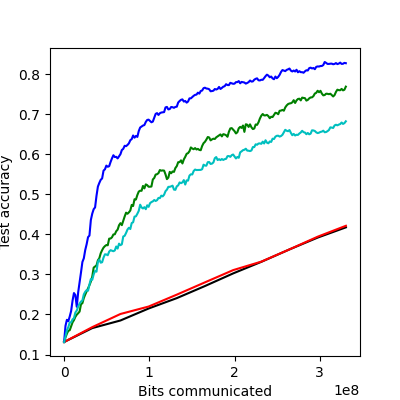

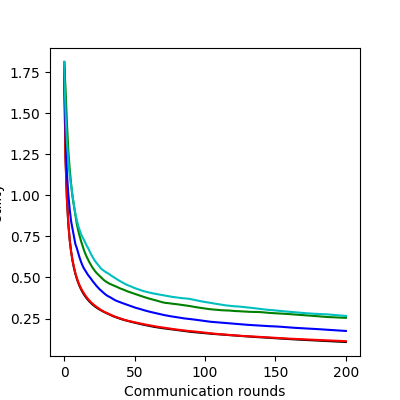

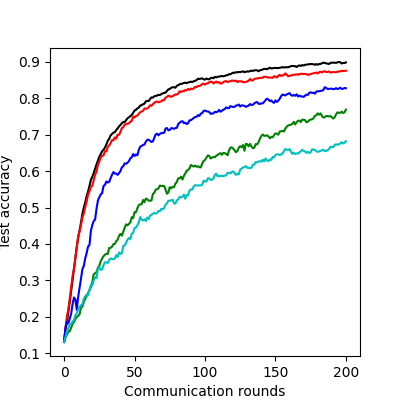

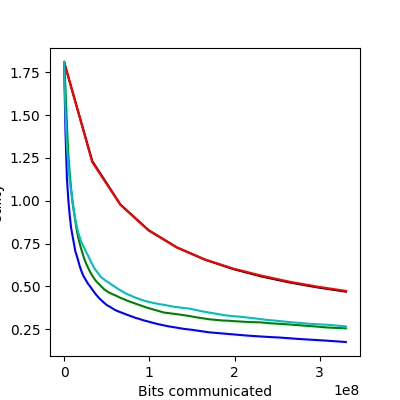

In [11]:
name = 'NN_eps_2'

for _, data in res:
    data['runnig_grad_norm'] = (data.grad_norm ** 2).cumsum() / (data.t + 1)

save_exp(res, configs, name, p=p, x_0=x_0)

legends = [_[0] for _, config in zip(res, configs)]
_ = plot_exp_final_final(res, name, save=True, legends=legends)
plt.show()

## eps = 1

In [12]:
n_agent = 10
np.random.seed(0)

p = NN(n_agent=n_agent, graph_params=0.8, dataset='mnist', sort=True, normalize_data=True)

dim = p.dim
x_0 = np.random.randn(dim) / 5

m = p.m
c = 48
print('p.m=', p.m)

np.random.seed(0)
n_iters = 150

common_config = {
    'n_iters': n_iters,
    'x_0': x_0.copy(),
    'extra_metrics': ['test_accuracy', 'grad_norm']
}

compression = {
    'compression': 'unbiased_random_sparsification',
    'compression_param': int(dim / 20)
}

omega = dim / compression['compression_param'] - 1
gamma = 1 / (1 + omega)

G = 1
epsilon = 1
delta = 1e-3

SGD_batch_size = 128
SoteriaFL_batch_size = int((p.m ** (2/3)) / 4)
SoteriaFL_prob = SoteriaFL_batch_size / p.m

perturbation_variance_CDP_SGD = np.sqrt(8 * G**2 * n_iters * (-np.log(delta)) / (m**2 * epsilon**2))
perturbation_variance_SoteriaFL_SVRG = np.sqrt(96 * G**2 * n_iters * (-np.log(delta)) / (m**2 * epsilon**2))
perturbation_variance_SoteriaFL_SGD = np.sqrt(12 * G**2 * n_iters * (-np.log(delta)) / (m**2 * epsilon**2))

gamma = np.sqrt((1 + 2 * omega) / (2 * ((1 + omega)**3)))

CDP_SGD_configs = [
    {'eta': 0.3, 'G': G, 'perturbation_variance': perturbation_variance_CDP_SGD, 'batch_size': SGD_batch_size, **compression},
]

SoteriaFL_configs = [
    {'eta': 0.6, 'gamma': gamma, 'local_update_method': 'sgd', 'G': G, 'perturbation_variance': perturbation_variance_SoteriaFL_SGD, 'batch_size': SGD_batch_size, **compression},
    {'eta': 0.3, 'gamma': gamma, 'local_update_method': 'svrg', 'G': G, 'perturbation_variance': perturbation_variance_SoteriaFL_SVRG, 'p_update_snapshot': SoteriaFL_prob, 'batch_size': SoteriaFL_batch_size, **compression},
]

LDP_SGD_configs = [
    {'eta': 1, 'G': G, 'perturbation_variance': perturbation_variance_CDP_SGD, 'batch_size': SGD_batch_size},
]

LDP_SVRG_configs = [
    {'eta': 1, 'G': G, 'perturbation_variance': perturbation_variance_SoteriaFL_SVRG, 'p_update_snapshot': SoteriaFL_prob, 'batch_size': SoteriaFL_batch_size},
]

configs, res = run()

INFO 23:07:34.6957 103983 dataset.py:32] Loading MNIST dataset from cached file
INFO 23:07:38.3264 103983 neural_network.py:48] Initialization done


p.m= 6000


INFO 23:07:44.1876 118554 utils.py:21] LDP_SGD started
INFO 23:07:50.8388 118629 utils.py:21] LDP_SVRG started
INFO 23:07:57.1604 118702 utils.py:21] CDP_SGD started
INFO 23:08:04.7317 118805 utils.py:21] SoteriaFL-SGD started
INFO 23:08:11.8539 118879 utils.py:21] SoteriaFL-SVRG started
INFO 23:08:16.7510 118554 utils.py:40] LDP_SGD done, total 32.56s
INFO 23:08:27.5021 118629 utils.py:40] LDP_SVRG done, total 36.66s
INFO 23:08:34.4669 118702 utils.py:40] CDP_SGD done, total 37.31s
INFO 23:08:39.3574 118805 utils.py:40] SoteriaFL-SGD done, total 34.63s
INFO 23:08:48.4531 118879 utils.py:40] SoteriaFL-SVRG done, total 36.60s
INFO 23:08:49.4517 103983 890834466.py:24] Total 71.06s


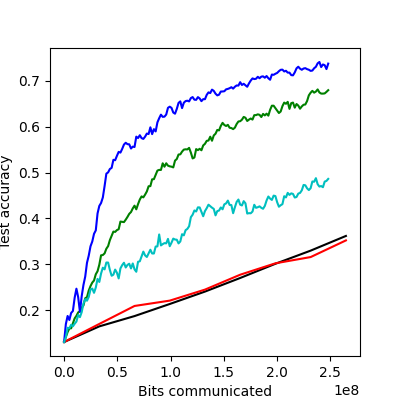

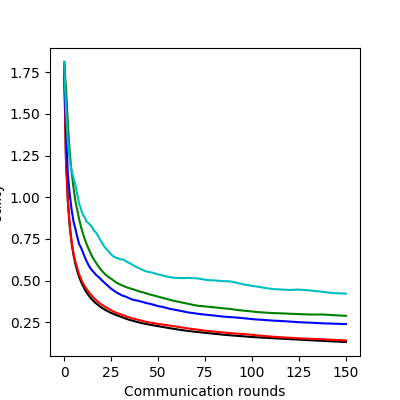

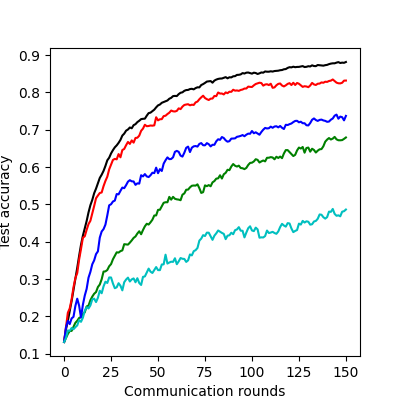

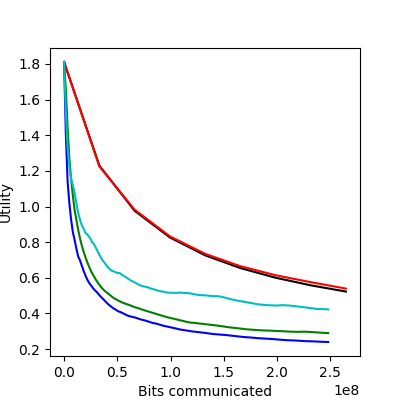

In [13]:
name = f'NN_eps_{epsilon}'

for _, data in res:
    data['runnig_grad_norm'] = (data.grad_norm ** 2).cumsum() / (data.t + 1)

save_exp(res, configs, name, p=p, x_0=x_0)

legends = [_[0] for _, config in zip(res, configs)]
_ = plot_exp_final_final(res, name, save=True, legends=legends)
plt.show()

## eps = 4

In [14]:
n_agent = 10
np.random.seed(0)

p = NN(n_agent=n_agent, graph_params=0.8, dataset='mnist', sort=True, normalize_data=True)

dim = p.dim
x_0 = np.random.randn(dim) / 5

m = p.m
c = 48
print('p.m=', p.m)

np.random.seed(0)
n_iters = 300

common_config = {
    'n_iters': n_iters,
    'x_0': x_0.copy(),
    'extra_metrics': ['test_accuracy', 'grad_norm']
}

compression = {
    'compression': 'unbiased_random_sparsification',
    'compression_param': int(dim / 20)
}

omega = dim / compression['compression_param'] - 1
gamma = 1 / (1 + omega)

G = 1
epsilon = 4
delta = 1e-3

SGD_batch_size = 128
SoteriaFL_batch_size = int((p.m ** (2/3)) / 4)
SoteriaFL_prob = SoteriaFL_batch_size / p.m

perturbation_variance_CDP_SGD = np.sqrt(8 * G**2 * n_iters * (-np.log(delta)) / (m**2 * epsilon**2))
perturbation_variance_SoteriaFL_SVRG = np.sqrt(96 * G**2 * n_iters * (-np.log(delta)) / (m**2 * epsilon**2))
perturbation_variance_SoteriaFL_SGD = np.sqrt(12 * G**2 * n_iters * (-np.log(delta)) / (m**2 * epsilon**2))

gamma = np.sqrt((1 + 2 * omega) / (2 * ((1 + omega)**3)))

CDP_SGD_configs = [
    {'eta': 0.6, 'G': G, 'perturbation_variance': perturbation_variance_CDP_SGD, 'batch_size': SGD_batch_size, **compression},
]

SoteriaFL_configs = [
    {'eta': 1, 'gamma': gamma, 'local_update_method': 'sgd', 'G': G, 'perturbation_variance': perturbation_variance_SoteriaFL_SGD, 'batch_size': SGD_batch_size, **compression},
    {'eta': 0.6, 'gamma': gamma, 'local_update_method': 'svrg', 'G': G, 'perturbation_variance': perturbation_variance_SoteriaFL_SVRG, 'p_update_snapshot': SoteriaFL_prob, 'batch_size': SoteriaFL_batch_size, **compression},
]

LDP_SGD_configs = [
    {'eta': 1, 'G': G, 'perturbation_variance': perturbation_variance_CDP_SGD, 'batch_size': SGD_batch_size},
]

LDP_SVRG_configs = [
    {'eta': 1, 'G': G, 'perturbation_variance': perturbation_variance_SoteriaFL_SVRG, 'p_update_snapshot': SoteriaFL_prob, 'batch_size': SoteriaFL_batch_size},
]

configs, res = run()

INFO 23:08:51.5744 103983 dataset.py:32] Loading MNIST dataset from cached file
INFO 23:08:55.5602 103983 neural_network.py:48] Initialization done


p.m= 6000


INFO 23:09:01.5576 119093 utils.py:21] LDP_SGD started
INFO 23:09:07.3621 119165 utils.py:21] LDP_SVRG started
INFO 23:09:13.7490 119238 utils.py:21] CDP_SGD started
INFO 23:09:21.1840 119312 utils.py:21] SoteriaFL-SGD started
INFO 23:09:27.5692 119394 utils.py:21] SoteriaFL-SVRG started
INFO 23:10:03.5931 119093 utils.py:40] LDP_SGD done, total 62.04s
INFO 23:10:13.1820 119165 utils.py:40] LDP_SVRG done, total 65.82s
INFO 23:10:15.4902 119238 utils.py:40] CDP_SGD done, total 61.74s
INFO 23:10:26.0568 119312 utils.py:40] SoteriaFL-SGD done, total 64.87s
INFO 23:10:36.4095 119394 utils.py:40] SoteriaFL-SVRG done, total 68.84s
INFO 23:10:37.6780 103983 890834466.py:24] Total 102.03s


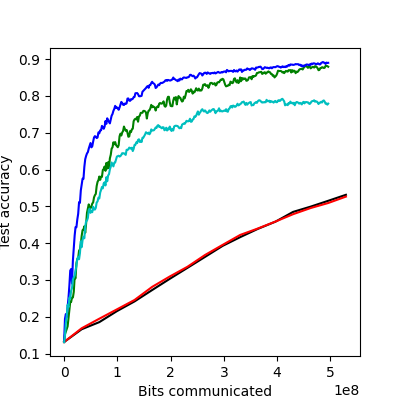

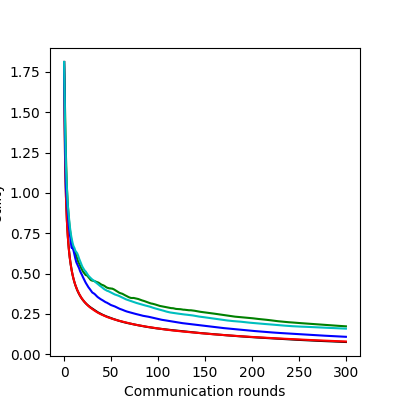

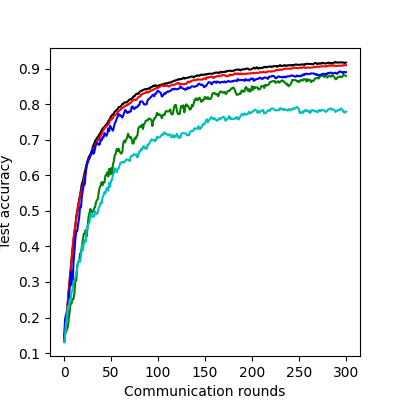

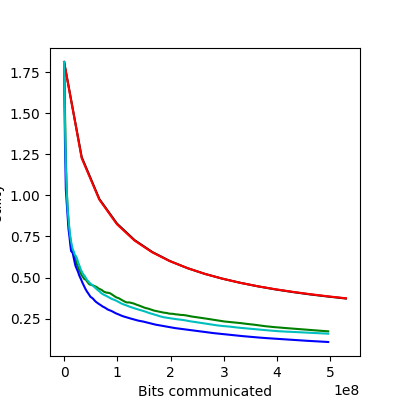

In [15]:
name = f'NN_eps_{epsilon}'
for _, data in res:
    data['runnig_grad_norm'] = (data.grad_norm ** 2).cumsum() / (data.t + 1)

save_exp(res, configs, name, p=p, x_0=x_0)

legends = [_[0] for _, config in zip(res, configs)]
_ = plot_exp_final_final(res, name, save=True, legends=legends)
plt.show()

## eps = 8

In [16]:
n_agent = 10
np.random.seed(0)

p = NN(n_agent=n_agent, graph_params=0.8, dataset='mnist', sort=True, normalize_data=True)

dim = p.dim
x_0 = np.random.randn(dim) / 5

m = p.m
c = 48
print('p.m=', p.m)

np.random.seed(0)
n_iters = 500

common_config = {
    'n_iters': n_iters,
    'x_0': x_0.copy(),
    'extra_metrics': ['test_accuracy', 'grad_norm']
}

compression = {
    'compression': 'unbiased_random_sparsification',
    'compression_param': int(dim / 20)
}

omega = dim / compression['compression_param'] - 1
gamma = 1 / (1 + omega)

G = 1
epsilon = 8
delta = 1e-3

SGD_batch_size = 128
SoteriaFL_batch_size = int((p.m ** (2/3)) / 4)
SoteriaFL_prob = SoteriaFL_batch_size / p.m

perturbation_variance_CDP_SGD = np.sqrt(8 * G**2 * n_iters * (-np.log(delta)) / (m**2 * epsilon**2))
perturbation_variance_SoteriaFL_SVRG = np.sqrt(96 * G**2 * n_iters * (-np.log(delta)) / (m**2 * epsilon**2))
perturbation_variance_SoteriaFL_SGD = np.sqrt(12 * G**2 * n_iters * (-np.log(delta)) / (m**2 * epsilon**2))

gamma = np.sqrt((1 + 2 * omega) / (2 * ((1 + omega)**3)))

CDP_SGD_configs = [
    {'eta': 0.6, 'G': G, 'perturbation_variance': perturbation_variance_CDP_SGD, 'batch_size': SGD_batch_size, **compression},
]

SoteriaFL_configs = [
    {'eta': 1, 'gamma': gamma, 'local_update_method': 'sgd', 'G': G, 'perturbation_variance': perturbation_variance_SoteriaFL_SGD, 'batch_size': SGD_batch_size, **compression},
    {'eta': 0.6, 'gamma': gamma, 'local_update_method': 'svrg', 'G': G, 'perturbation_variance': perturbation_variance_SoteriaFL_SVRG, 'p_update_snapshot': SoteriaFL_prob, 'batch_size': SoteriaFL_batch_size, **compression},
]

LDP_SGD_configs = [
    {'eta': 1, 'G': G, 'perturbation_variance': perturbation_variance_CDP_SGD, 'batch_size': SGD_batch_size},
]

LDP_SVRG_configs = [
    {'eta': 1, 'G': G, 'perturbation_variance': perturbation_variance_SoteriaFL_SVRG, 'p_update_snapshot': SoteriaFL_prob, 'batch_size': SoteriaFL_batch_size},
]

configs, res = run()

INFO 23:10:39.8434 103983 dataset.py:32] Loading MNIST dataset from cached file
INFO 23:10:44.2716 103983 neural_network.py:48] Initialization done


p.m= 6000


INFO 23:10:50.0214 119610 utils.py:21] LDP_SGD started
INFO 23:10:55.8064 119683 utils.py:21] LDP_SVRG started
INFO 23:11:02.3356 119784 utils.py:21] CDP_SGD started
INFO 23:11:09.3341 120304 utils.py:21] SoteriaFL-SGD started
INFO 23:11:17.2417 120386 utils.py:21] SoteriaFL-SVRG started
INFO 23:12:33.8910 119610 utils.py:40] LDP_SGD done, total 103.87s
INFO 23:12:43.6922 119683 utils.py:40] LDP_SVRG done, total 107.89s
INFO 23:12:46.2158 119784 utils.py:40] CDP_SGD done, total 103.88s
INFO 23:13:09.4491 120304 utils.py:40] SoteriaFL-SGD done, total 120.11s
INFO 23:13:13.7340 120386 utils.py:40] SoteriaFL-SVRG done, total 116.49s
INFO 23:13:14.7496 103983 890834466.py:24] Total 150.40s


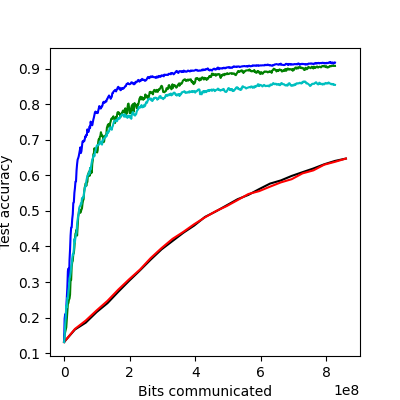

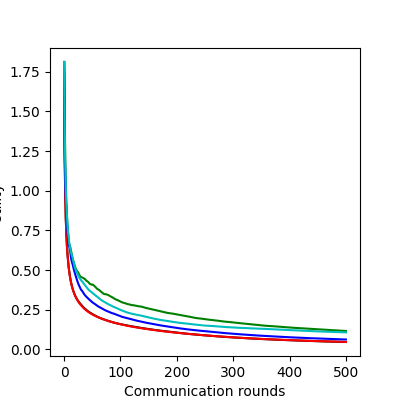

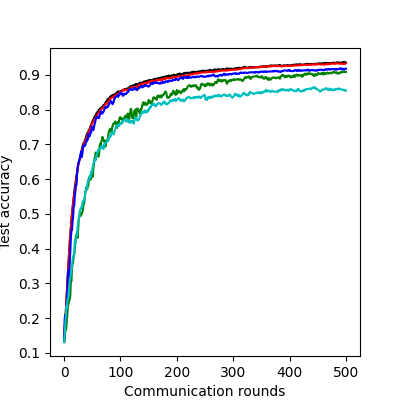

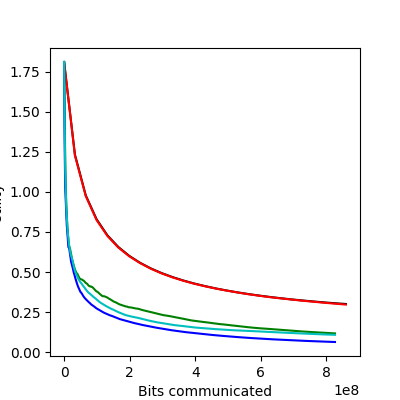

In [17]:
name = f'NN_eps_{epsilon}'

for _, data in res:
    data['runnig_grad_norm'] = (data.grad_norm ** 2).cumsum() / (data.t + 1)

save_exp(res, configs, name, p=p, x_0=x_0)

legends = [_[0] for _, config in zip(res, configs)]
_ = plot_exp_final_final(res, name, save=True, legends=legends)
plt.show()

## eps = 16

In [18]:
n_agent = 10
np.random.seed(0)

p = NN(n_agent=n_agent, graph_params=0.8, dataset='mnist', sort=True, normalize_data=True)

dim = p.dim
x_0 = np.random.randn(dim) / 5

m = p.m
c = 48
print('p.m=', p.m)

np.random.seed(0)
n_iters = 1000

common_config = {
    'n_iters': n_iters,
    'x_0': x_0.copy(),
    'extra_metrics': ['test_accuracy', 'grad_norm']
}

compression = {
    'compression': 'unbiased_random_sparsification',
    'compression_param': int(dim / 20)
}

omega = dim / compression['compression_param'] - 1
gamma = 1 / (1 + omega)

G = 1
epsilon = 16
delta = 1e-3

SGD_batch_size = 128
SoteriaFL_batch_size = int((p.m ** (2/3)) / 4)
SoteriaFL_prob = SoteriaFL_batch_size / p.m

perturbation_variance_CDP_SGD = np.sqrt(8 * G**2 * n_iters * (-np.log(delta)) / (m**2 * epsilon**2))
perturbation_variance_SoteriaFL_SVRG = np.sqrt(96 * G**2 * n_iters * (-np.log(delta)) / (m**2 * epsilon**2))
perturbation_variance_SoteriaFL_SGD = np.sqrt(12 * G**2 * n_iters * (-np.log(delta)) / (m**2 * epsilon**2))

gamma = np.sqrt((1 + 2 * omega) / (2 * ((1 + omega)**3)))

CDP_SGD_configs = [
    {'eta': 0.6, 'G': G, 'perturbation_variance': perturbation_variance_CDP_SGD, 'batch_size': SGD_batch_size, **compression},
]

SoteriaFL_configs = [
    {'eta': 1, 'gamma': gamma, 'local_update_method': 'sgd', 'G': G, 'perturbation_variance': perturbation_variance_SoteriaFL_SGD, 'batch_size': SGD_batch_size, **compression},
    {'eta': 0.6, 'gamma': gamma, 'local_update_method': 'svrg', 'G': G, 'perturbation_variance': perturbation_variance_SoteriaFL_SVRG, 'p_update_snapshot': SoteriaFL_prob, 'batch_size': SoteriaFL_batch_size, **compression},
]

LDP_SGD_configs = [
    {'eta': 1, 'G': G, 'perturbation_variance': perturbation_variance_CDP_SGD, 'batch_size': SGD_batch_size},
]

LDP_SVRG_configs = [
    {'eta': 1, 'G': G, 'perturbation_variance': perturbation_variance_SoteriaFL_SVRG, 'p_update_snapshot': SoteriaFL_prob, 'batch_size': SoteriaFL_batch_size},
]

configs, res = run()

INFO 23:13:17.1628 103983 dataset.py:32] Loading MNIST dataset from cached file
INFO 23:13:20.6130 103983 neural_network.py:48] Initialization done


p.m= 6000


INFO 23:13:26.3206 120676 utils.py:21] LDP_SGD started
INFO 23:13:32.0117 120750 utils.py:21] LDP_SVRG started
INFO 23:13:38.6371 120822 utils.py:21] CDP_SGD started
INFO 23:13:45.3366 120900 utils.py:21] SoteriaFL-SGD started
INFO 23:13:51.7950 120975 utils.py:21] SoteriaFL-SVRG started
INFO 23:16:43.5266 120676 utils.py:40] LDP_SGD done, total 197.21s
INFO 23:16:56.4218 120822 utils.py:40] CDP_SGD done, total 197.78s
INFO 23:17:03.7647 120750 utils.py:40] LDP_SVRG done, total 211.75s
INFO 23:17:21.5059 120900 utils.py:40] SoteriaFL-SGD done, total 216.17s
INFO 23:17:42.6431 120975 utils.py:40] SoteriaFL-SVRG done, total 230.85s
INFO 23:17:44.0395 103983 890834466.py:24] Total 263.32s


/tmp/ipykernel_103983/2578702185.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  objs = [plt.subplots(1, 1, figsize=(4, 4)) for i in range(4)]


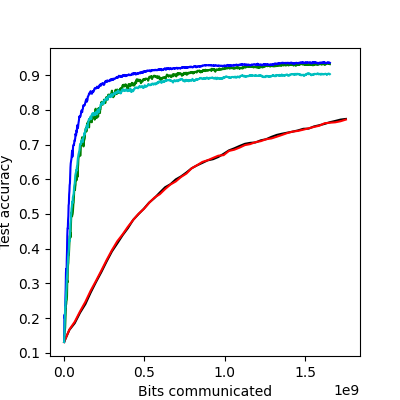

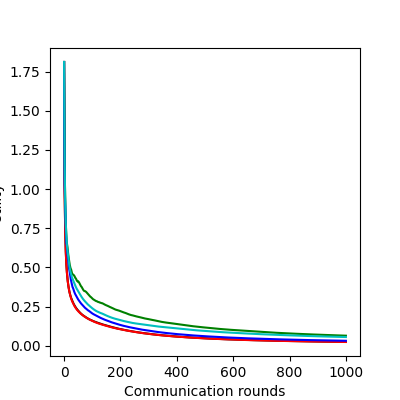

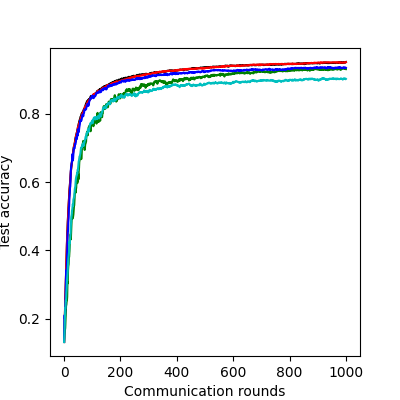

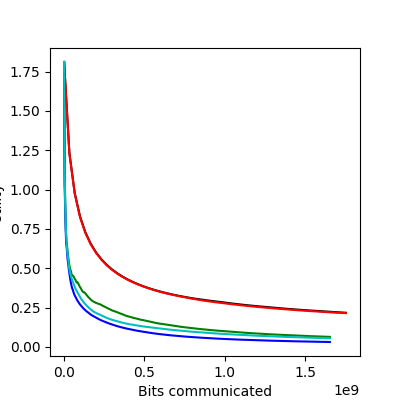

In [19]:
name = f'NN_eps_{epsilon}'

for _, data in res:
    data['runnig_grad_norm'] = (data.grad_norm ** 2).cumsum() / (data.t + 1)

save_exp(res, configs, name, p=p, x_0=x_0)

legends = [_[0] for _, config in zip(res, configs)]
_ = plot_exp_final_final(res, name, save=True, legends=legends)
plt.show()